In [2]:
# Use a conda env with bitbirch installed
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
from collections import Counter
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import os

# Define root directory
# root = os.path.dirname(os.path.abspath(__file__))
root = "."
sys.path.append(os.path.join(root, "..", "src"))
from default import CONFIGPATH

# Loading ChEMBL preprocessed data
print("Loading ChEMBL preprocessed data...")
ChEMBL = pd.read_csv(os.path.join(root, "..", "config", "chembl_processed", "activities_preprocessed.csv"), low_memory=False)

Loading ChEMBL preprocessed data...


In [3]:
print(f"Number of activities: {len(ChEMBL)}")
print(f"Number of activities with non nan values: {len(ChEMBL[ChEMBL['value'].isna() == False])}")
print(f"Number of unique compounds: {len(set(ChEMBL['compound_chembl_id']))}")
print(f"Number of unique assays: {len(set(ChEMBL['assay_chembl_id']))}")
print(f'Assay types: {Counter(ChEMBL[["assay_chembl_id", "assay_type"]].drop_duplicates(subset="assay_chembl_id")["assay_type"])}')
print(f"Number of unique targets: {len(set(ChEMBL['target_chembl_id']))}")
print(f'Target types: {Counter(ChEMBL[["target_chembl_id", "target_type"]].drop_duplicates(subset="target_chembl_id")["target_type"])}')
print(f"Relations: {Counter(ChEMBL['relation'])}")
print(f"Original pChEMBL: {len(ChEMBL[ChEMBL['pchembl'].isna() == False])}")
print(f"Calculated pChEMBL: {len(ChEMBL[ChEMBL['pchembl_calculated'].isna() == False])}")

thr = 0.01
ChEMBL_filtered = ChEMBL[(ChEMBL['pchembl'].isna() == False) & (ChEMBL['pchembl_calculated'].isna() == False)].copy()
ChEMBL_filtered['pchembl'] = ChEMBL_filtered['pchembl'].clip(lower=1, upper=9)
ChEMBL_filtered = ChEMBL_filtered[["pchembl", "pchembl_calculated"]]
ChEMBL_filtered['difference'] = [np.abs(i-j) for i,j in zip(ChEMBL_filtered['pchembl'], ChEMBL_filtered['pchembl_calculated'])]
perc = len(ChEMBL_filtered[ChEMBL_filtered['difference'] < thr]) * 100 / len(ChEMBL_filtered)
print(f"Percentage of pChEMBL original vs calculated having difference < {thr}: {perc}")

Number of activities: 24040987
Number of activities with non nan values: 20718584
Number of unique compounds: 2756399
Number of unique assays: 1884335
Assay types: Counter({'F': 880634, 'B': 595493, 'A': 309873, 'T': 68068, 'P': 26580, 'U': 3687})
Number of unique targets: 17300
Target types: Counter({'SINGLE PROTEIN': 10727, 'ORGANISM': 2381, 'CELL-LINE': 1984, 'PROTEIN COMPLEX': 599, 'PROTEIN-PROTEIN INTERACTION': 595, 'PROTEIN FAMILY': 393, 'TISSUE': 294, 'SELECTIVITY GROUP': 123, 'NUCLEIC-ACID': 56, 'PROTEIN COMPLEX GROUP': 55, 'CHIMERIC PROTEIN': 34, 'UNKNOWN': 16, 'SUBCELLULAR': 12, 'MACROMOLECULE': 7, 'PROTEIN NUCLEIC-ACID COMPLEX': 6, '3D CELL CULTURE': 6, 'SMALL MOLECULE': 4, 'PHENOTYPE': 2, 'NON-MOLECULAR': 1, 'ADMET': 1, 'UNCHECKED': 1, 'NO TARGET': 1, 'LIPID': 1, 'OLIGOSACCHARIDE': 1})
Relations: Counter({'=': 22097792, '>': 1569365, '<': 373830})
Original pChEMBL: 4887128
Calculated pChEMBL: 13712063
Percentage of pChEMBL original vs calculated having difference < 0.01: 10

In [4]:
LABEL = 'activity_type'
print(f"Number of standard activity types: {len(set(ChEMBL[LABEL]))}")
s = ChEMBL[[LABEL]].astype("string").fillna("")
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"100 types coverage: {out['cumulative_prop'].tolist()[100]}")

Number of standard activity types: 6020
100 types coverage: 0.951


In [5]:
LABEL = 'unit'
print(f"Number of units: {len(set(ChEMBL[LABEL]))}")
s = ChEMBL[[LABEL]].astype("string").fillna("")
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"100 units coverage: {out['cumulative_prop'].tolist()[100]}")

Number of units: 2502
100 units coverage: 0.997


In [6]:
LABEL = ['activity_type', 'unit']
s = pd.DataFrame([str(i) + " -- " + str(j) for i,j in zip(ChEMBL[LABEL[0]], ChEMBL[LABEL[1]])])
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"Number of act-unit pairs: {len(out)}")
print(f"100 pairs coverage: {out['cumulative_prop'].tolist()[100]}")

Number of act-unit pairs: 12694
100 pairs coverage: 0.935


In [7]:
### FILTERING FOR PATHOGENS ###

def get_pathogen_code(pathogen):
    return str(pathogen.split()[0][0] + pathogen.split()[1]).lower() if len(pathogen.split()) > 1 else pathogen.lower()

In [8]:
# List of pathogens
pathogens = ["Acinetobacter baumannii", "Candida albicans", "Campylobacter", "Escherichia coli", "Enterococcus faecium", "Enterobacter",
             "Helicobacter pylori", "Klebsiella pneumoniae", "Mycobacterium tuberculosis", "Neisseria gonorrhoeae", "Pseudomonas aeruginosa",
             "Plasmodium falciparum", "Staphylococcus aureus", "Schistosoma mansoni", "Streptococcus pneumoniae"]

RESULTS = {}
# For each pathogen
pathogens = np.array(pathogens)
for pathogen in pathogens:

    print(f"Filtering for pathogen: {pathogen}...")
    pathogen_code = get_pathogen_code(pathogen)
    pathogen_data = ChEMBL[ChEMBL['target_organism'].str.contains(pathogen, case=False, na=False) | 
                    ChEMBL['assay_organism'].str.contains(pathogen, case=False, na=False)].reset_index(drop=True)

    print(f"Number of activities: {len(pathogen_data)}")
    print(f"Number of unique compounds: {len(set(pathogen_data['compound_chembl_id']))}")
    RESULTS[pathogen_code] = [len(pathogen_data), len(set(pathogen_data['compound_chembl_id']))]
    print("\n")

Filtering for pathogen: Acinetobacter baumannii...
Number of activities: 45869
Number of unique compounds: 32898


Filtering for pathogen: Candida albicans...
Number of activities: 92169
Number of unique compounds: 44545


Filtering for pathogen: Campylobacter...
Number of activities: 2183
Number of unique compounds: 691


Filtering for pathogen: Escherichia coli...
Number of activities: 282516
Number of unique compounds: 155454


Filtering for pathogen: Enterococcus faecium...
Number of activities: 15713
Number of unique compounds: 8148


Filtering for pathogen: Enterobacter...
Number of activities: 12298
Number of unique compounds: 5996


Filtering for pathogen: Helicobacter pylori...
Number of activities: 5142
Number of unique compounds: 1808


Filtering for pathogen: Klebsiella pneumoniae...
Number of activities: 50234
Number of unique compounds: 26881


Filtering for pathogen: Mycobacterium tuberculosis...
Number of activities: 714221
Number of unique compounds: 132378


Filtering

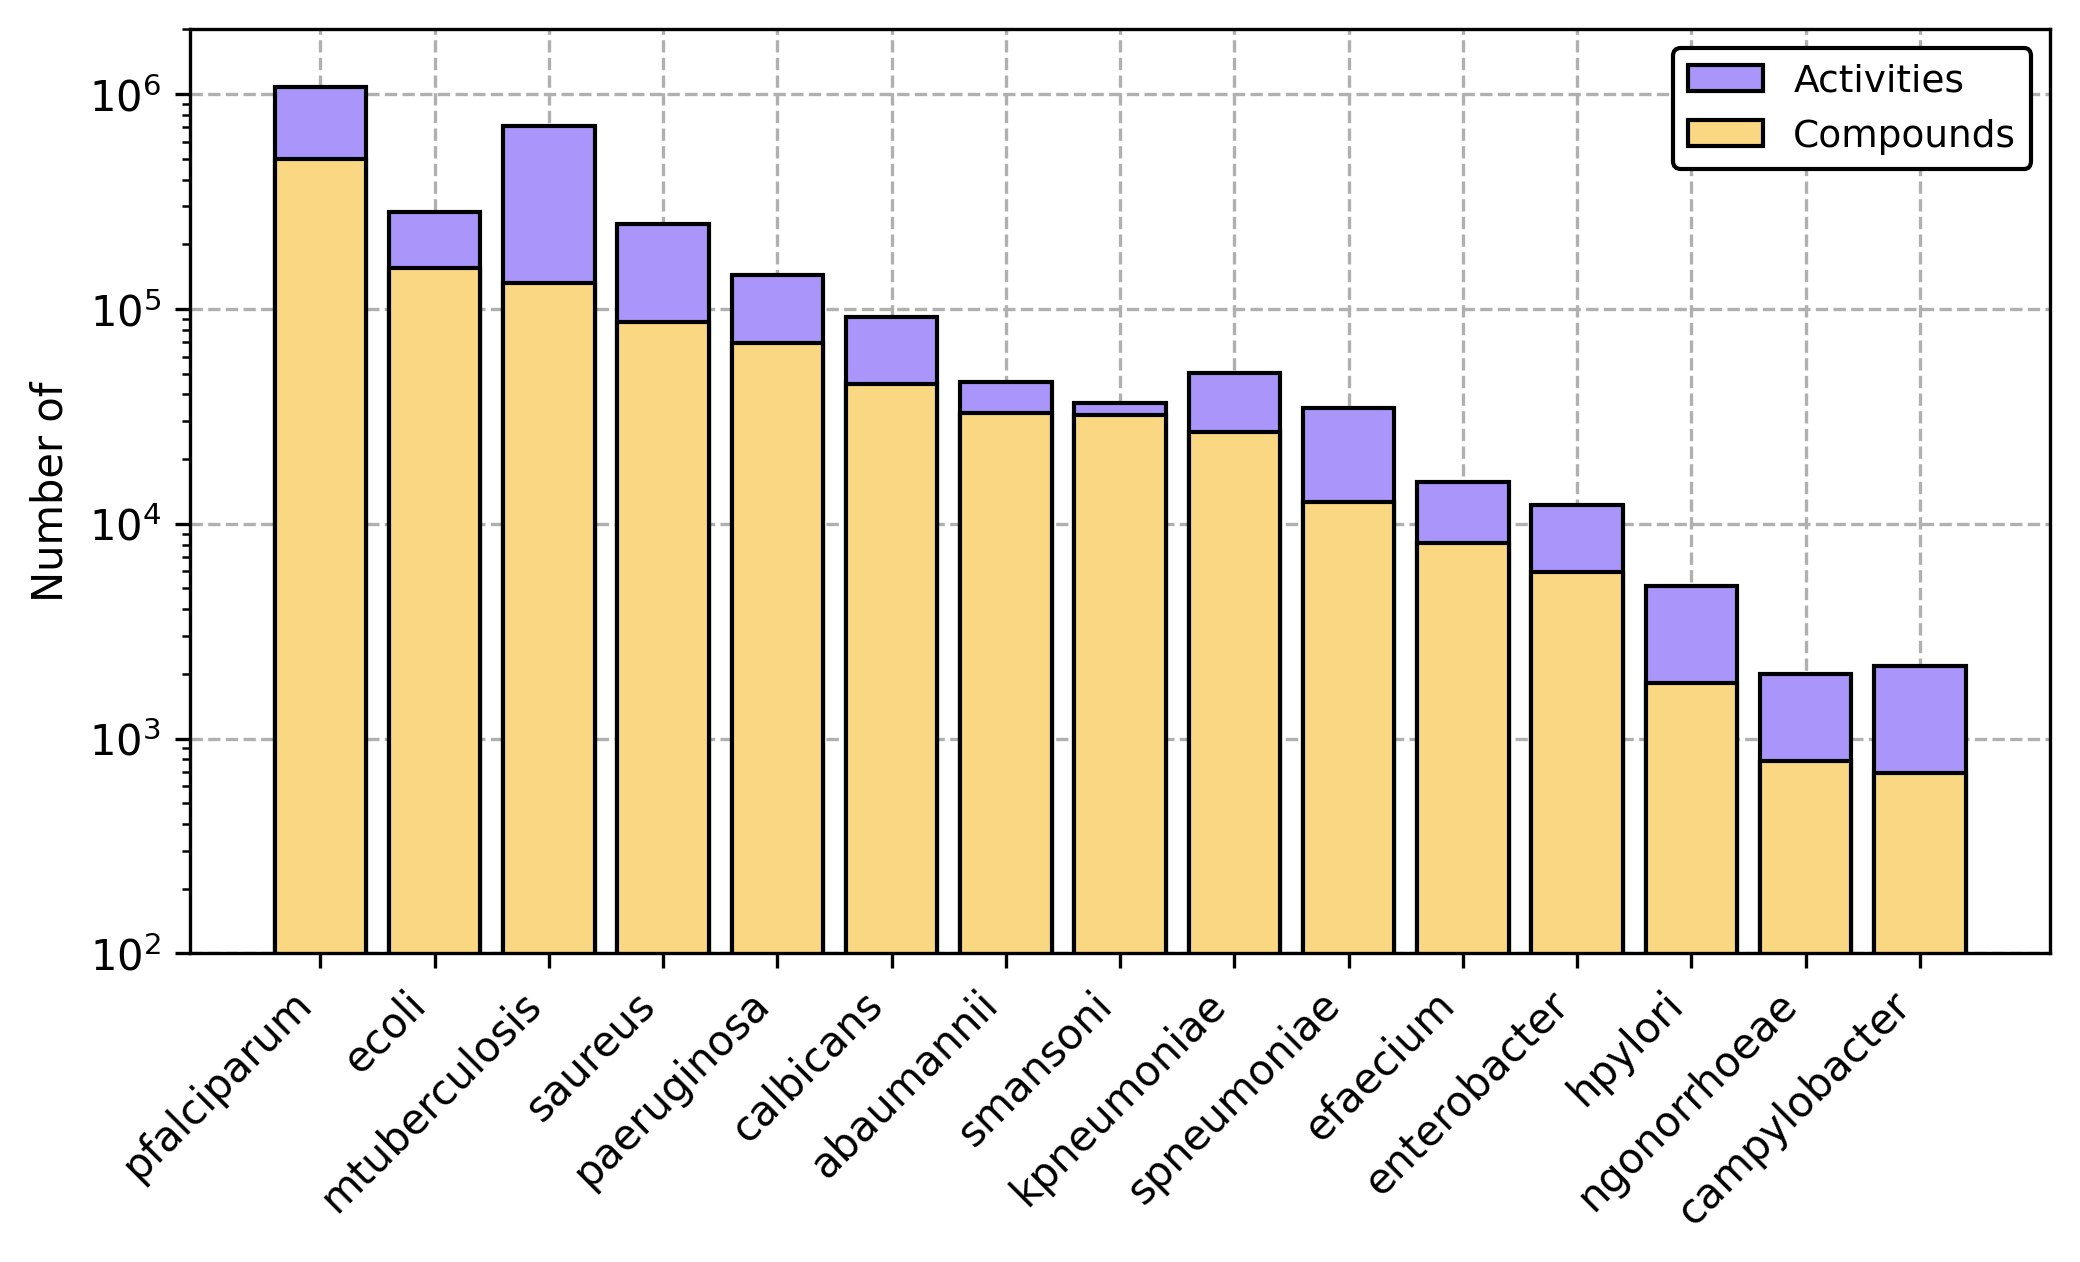

In [17]:
plt.figure(figsize=(8, 4))

x = [i for i in range(len(pathogens))]
inds = np.argsort([RESULTS[get_pathogen_code(i)][1] for i in pathogens])[::-1]
plt.bar(x, [RESULTS[get_pathogen_code(i)][0] for i in pathogens[inds]], zorder=2, ec='k', color="#AA96FA", label='Activities')
plt.bar(x, [RESULTS[get_pathogen_code(i)][1] for i in pathogens[inds]], zorder=2, ec='k', color="#FAD782", label='Compounds')

plt.ylim([10 ** 2, 2*10 ** 6])
plt.yscale('log')
plt.ylabel("Number of")
plt.xticks(x, [get_pathogen_code(i) for i in pathogens[inds]], rotation=45, ha='right')
plt.grid(linestyle='--')
plt.legend(loc='upper right', framealpha=1, edgecolor='k', prop={'size': 9})
plt.show()

In [10]:
# Filtering data for pathogens
pathogen_data = ChEMBL[ChEMBL['target_organism'].str.lower().isin([p.lower() for p in pathogens]) | 
                       ChEMBL['assay_organism'].str.lower().isin([p.lower() for p in pathogens])].reset_index(drop=True)

In [11]:
print(f"Number of activities: {len(pathogen_data)}")
print(f"Number of activities with non nan values: {len(pathogen_data[pathogen_data['value'].isna() == False])}")
print(f"Number of unique compounds: {len(set(pathogen_data['compound_chembl_id']))}")
print(f"Number of unique assays: {len(set(pathogen_data['assay_chembl_id']))}")
print(f'Assay types: {Counter(pathogen_data[["assay_chembl_id", "assay_type"]].drop_duplicates(subset="assay_chembl_id")["assay_type"])}')
print(f"Number of unique targets: {len(set(pathogen_data['target_chembl_id']))}")
print(f'Target types: {Counter(pathogen_data[["target_chembl_id", "target_type"]].drop_duplicates(subset="target_chembl_id")["target_type"])}')
print(f"Relations: {Counter(pathogen_data['relation'])}")
print(f"Original pChEMBL: {len(pathogen_data[pathogen_data['pchembl'].isna() == False])}")
print(f"Calculated pChEMBL: {len(pathogen_data[pathogen_data['pchembl_calculated'].isna() == False])}")

thr = 0.01
pathogen_data_filtered = pathogen_data[(pathogen_data['pchembl'].isna() == False) & (pathogen_data['pchembl_calculated'].isna() == False)].copy()
pathogen_data_filtered['pchembl'] = pathogen_data_filtered['pchembl'].clip(lower=1, upper=9)
pathogen_data_filtered = pathogen_data_filtered[["pchembl", "pchembl_calculated"]]
pathogen_data_filtered['difference'] = [np.abs(i-j) for i,j in zip(pathogen_data_filtered['pchembl'], pathogen_data_filtered['pchembl_calculated'])]
perc = len(pathogen_data_filtered[pathogen_data_filtered['difference'] < thr]) * 100 / len(pathogen_data_filtered)
print(f"Percentage of pChEMBL original vs calculated having difference < {thr}: {perc}")

Number of activities: 2725613
Number of activities with non nan values: 2610858
Number of unique compounds: 710802
Number of unique assays: 128689
Assay types: Counter({'F': 111241, 'B': 16005, 'A': 1273, 'T': 151, 'U': 14, 'P': 5})
Number of unique targets: 798
Target types: Counter({'SINGLE PROTEIN': 724, 'ORGANISM': 23, 'PROTEIN COMPLEX': 17, 'PROTEIN FAMILY': 8, 'NUCLEIC-ACID': 5, 'MACROMOLECULE': 4, 'SUBCELLULAR': 4, 'SMALL MOLECULE': 2, 'PROTEIN COMPLEX GROUP': 2, 'CELL-LINE': 2, 'UNCHECKED': 1, 'NON-MOLECULAR': 1, 'ADMET': 1, 'NO TARGET': 1, 'PROTEIN NUCLEIC-ACID COMPLEX': 1, 'UNKNOWN': 1, 'LIPID': 1})
Relations: Counter({'=': 2550060, '>': 155126, '<': 20427})
Original pChEMBL: 220565
Calculated pChEMBL: 1117743
Percentage of pChEMBL original vs calculated having difference < 0.01: 100.0


In [12]:
LABEL = 'activity_type'
print(f"Number of standard activity types: {len(set(pathogen_data[LABEL]))}")
s = pathogen_data[[LABEL]].astype("string").fillna("")
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"100 types coverage: {out['cumulative_prop'].tolist()[100]}")

Number of standard activity types: 480
100 types coverage: 0.996


In [13]:
LABEL = 'unit'
print(f"Number of units: {len(set(pathogen_data[LABEL]))}")
s = pathogen_data[[LABEL]].astype("string").fillna("")
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"100 units coverage: {out['cumulative_prop'].tolist()[100]}")

Number of units: 238
100 units coverage: 1.0


In [14]:
LABEL = ['activity_type', 'unit']
s = pd.DataFrame([str(i) + " -- " + str(j) for i,j in zip(pathogen_data[LABEL[0]], pathogen_data[LABEL[1]])])
out = (s.value_counts(dropna=False).reset_index(name="count").sort_values("count", ascending=False, ignore_index=True))
total_count = out['count'].sum()
out['cumulative_prop'] = (out['count'].cumsum() / total_count).round(3)
print(f"Number of act-unit pairs: {len(out)}")
print(f"100 pairs coverage: {out['cumulative_prop'].tolist()[100]}")

Number of act-unit pairs: 961
100 pairs coverage: 0.991


In [15]:
out[:10]

,0,count,cumulative_prop
0,PERCENTEFFECT -- %,754691,0.277
1,INHIBITION -- %,467165,0.448
2,MIC -- umol.L-1,455636,0.615
3,POTENCY -- umol.L-1,392785,0.760
4,ZSCORE -- nan,147589,0.814
5,IC50 -- umol.L-1,123371,0.859
6,ACTIVITY -- nan,55292,0.879
7,IZ -- mm,45471,0.896
8,EC50 -- umol.L-1,31281,0.907
9,ACTIVITY -- %,17803,0.914


In [40]:
# From Assay ChEMBL ID to number of nans / non-nans
PATHOGEN_ASSAYS = set(pathogen_data['assay_chembl_id'])
PATHOGEN_ASSAYS = {i: {'nans': set(), 'non-nans': set()} for i in PATHOGEN_ASSAYS}

# Collect info
for activity_id, assay_chembl_id, value in tqdm(zip(pathogen_data['activity_id'], pathogen_data['assay_chembl_id'], pathogen_data['value'])):
    if np.isnan(value):
        PATHOGEN_ASSAYS[assay_chembl_id]['nans'].add(activity_id)
    else:
        PATHOGEN_ASSAYS[assay_chembl_id]['non-nans'].add(activity_id)

# Assays with at least one nan
assays_nan_values = Counter(pathogen_data[pathogen_data['value'].isna()]['assay_chembl_id'])
print(f"Number of assays with at least one nan value: {len(assays_nan_values)}")
assert len(assays_nan_values) == len([i for i in PATHOGEN_ASSAYS if len(PATHOGEN_ASSAYS[i]['nans']) > 0])

2725613it [00:02, 1215341.03it/s]

Number of assays with at least one nan value: 28863


In [41]:
# Calculate proportion of nans
proportion_nans = {}
for assay in sorted(PATHOGEN_ASSAYS):
    if len(PATHOGEN_ASSAYS[assay]['nans']) > 0:
        proportion_nans[assay] = len(PATHOGEN_ASSAYS[assay]['nans']) / (len(PATHOGEN_ASSAYS[assay]['nans']) + len(PATHOGEN_ASSAYS[assay]['non-nans']))

print(len(proportion_nans))

28863


In [42]:
len([i for i in proportion_nans if (len(PATHOGEN_ASSAYS[i]['nans']) + len (PATHOGEN_ASSAYS[i]['non-nans'])) == 1])

12347

In [43]:
len([i for i in proportion_nans if (len(PATHOGEN_ASSAYS[i]['nans']) + len (PATHOGEN_ASSAYS[i]['non-nans'])) > 1 and proportion_nans[i] > 0.9])

9285

In [30]:
# pathogen_data[pathogen_data['assay_chembl_id'] == "CHEMBL1003929"]